## 1. Setup and Imports

In [1]:
import os
import torch
import torchvision
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms, datasets
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from transformers import ViTForImageClassification, ViTFeatureExtractor, CLIPProcessor, CLIPModel


## 2. DataModule Definition

In [2]:
class Food11DataModule(pl.LightningDataModule):
    def __init__(self, data_dir="data/food11", batch_size=32, img_size=224, num_workers=4):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.num_workers = num_workers

    def setup(self, stage=None):
        transform = transforms.Compose([
            transforms.Resize((self.img_size, self.img_size)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),
        ])
        self.train_dataset = datasets.ImageFolder(os.path.join(self.data_dir, "training"), transform=transform)
        self.val_dataset = datasets.ImageFolder(os.path.join(self.data_dir, "validation"), transform=transform)
        self.class_names = self.train_dataset.classes

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False)


### Test Classes and Data Preview

In [3]:
dm = Food11DataModule()
dm.setup()
print("Class names:", dm.class_names)

# Preview one batch
images, labels = next(iter(dm.train_dataloader()))
print("Batch shape:", images.shape)
print("Sample labels:", labels[:6])

Class names: ['Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 'Meat', 'Noodles-Pasta', 'Rice', 'Seafood', 'Soup', 'Vegetable-Fruit']
Batch shape: torch.Size([32, 3, 224, 224])
Sample labels: tensor([4, 5, 2, 3, 9, 5])


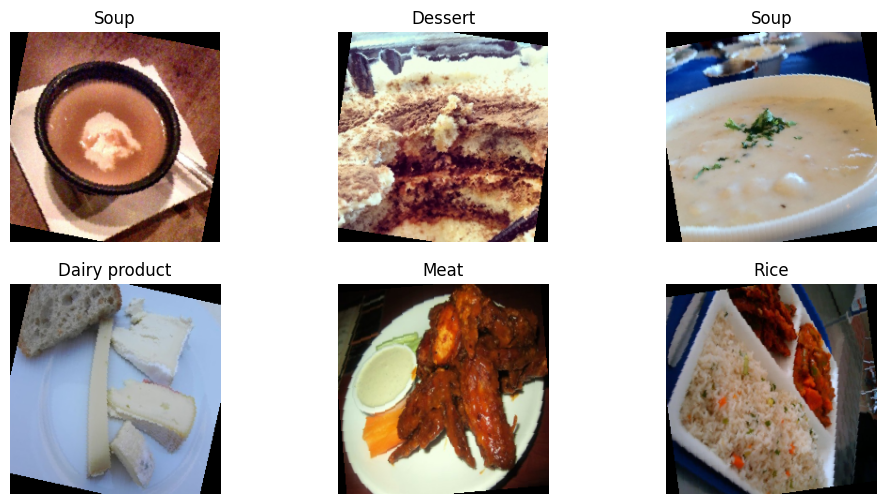

In [4]:
import matplotlib.pyplot as plt

sample_loader = dm.train_dataloader()
images, labels = next(iter(sample_loader))
class_names = dm.class_names

plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(images[i].permute(1, 2, 0).numpy() * 0.5 + 0.5)
    plt.title(class_names[labels[i]])
    plt.axis("off")


## 3. Lightning Module for ViT

In [5]:
class Food11ViTModule(pl.LightningModule):
    def __init__(self, num_classes=11, lr=2e-5):
        super().__init__()
        self.save_hyperparameters()
        self.model = ViTForImageClassification.from_pretrained(
            "google/vit-base-patch16-224",
            num_labels=num_classes,
            ignore_mismatched_sizes=True
        )
        self.criterion = torch.nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x).logits

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("train_loss", loss, on_epoch=True)
        self.log("train_acc", acc, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("val_loss", loss, on_epoch=True)
        self.log("val_acc", acc, on_epoch=True)

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.hparams.lr)


## 4. Training the Model (with TensorBoard, no checkpoints)

In [8]:
logger = TensorBoardLogger("runs", name="food11_vit", log_graph=False)

trainer = Trainer(
    max_epochs=5,
    logger=logger,
    enable_checkpointing=False,
    log_every_n_steps=100,
    accelerator="auto"
)

#Not Sure if needed
# dm = Food11DataModule()
# dm.setup()

model = Food11ViTModule(num_classes=len(dm.class_names))
trainer.fit(model, dm)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([11]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([11, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params | Mode 
----------------------------------------------------------------
0 | model     | ViTForImageClassification | 85.8 M | eval 
1 | criterion | CrossEntropyLoss          | 0      | train
----------------------------------------------------------------
85.8 M    Trainable params
0         Non-trainable params
85.8 M    Total params
343.228   Total estimated model para

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


## 5. Save Model for Hugging Face

In [9]:
model.model.save_pretrained("food11-vit")
extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")
extractor.save_pretrained("food11-vit")


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


['food11-vit/preprocessor_config.json']

## 6. Visualize Class Distribution

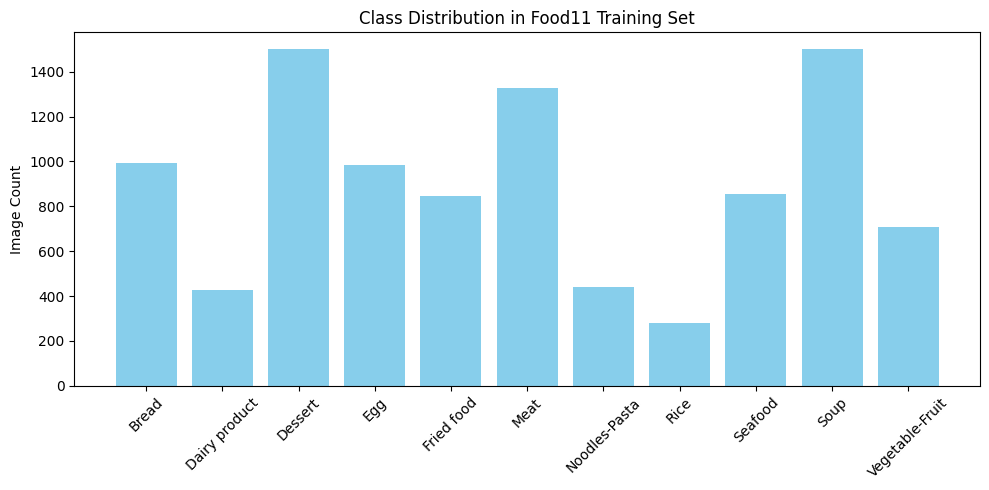

In [10]:
data_dir = "data/food11/training"
classes = os.listdir(data_dir)
counts = [len(os.listdir(os.path.join(data_dir, cls))) for cls in classes]

plt.figure(figsize=(10, 5))
plt.bar(classes, counts, color="skyblue")
plt.xticks(rotation=45)
plt.title("Class Distribution in Food11 Training Set")
plt.ylabel("Image Count")
plt.tight_layout()

os.makedirs("doc", exist_ok=True)
plt.savefig("doc/class_distribution.png")
plt.show()


## 7. Zero-Shot Comparison using CLIP


📷 12.jpg
                 bread: 0.0012
         dairy product: 0.0363
               dessert: 0.2029
                   egg: 0.7178
            fried food: 0.0012
                  meat: 0.0002
      noodles or pasta: 0.0001
                  rice: 0.0017
               seafood: 0.0273
                  soup: 0.0013
  vegetables or fruits: 0.0101


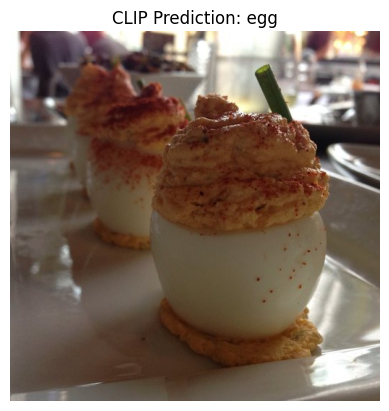


📷 99.jpg
                 bread: 0.0002
         dairy product: 0.0277
               dessert: 0.0007
                   egg: 0.0001
            fried food: 0.0016
                  meat: 0.0010
      noodles or pasta: 0.0010
                  rice: 0.0008
               seafood: 0.0073
                  soup: 0.9592
  vegetables or fruits: 0.0005


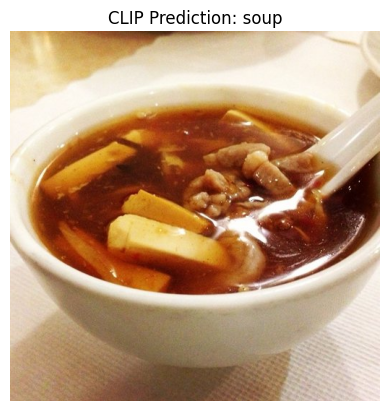


📷 33.jpg
                 bread: 0.0000
         dairy product: 0.0005
               dessert: 0.0000
                   egg: 0.0001
            fried food: 0.0008
                  meat: 0.0001
      noodles or pasta: 0.0000
                  rice: 0.9960
               seafood: 0.0003
                  soup: 0.0000
  vegetables or fruits: 0.0021


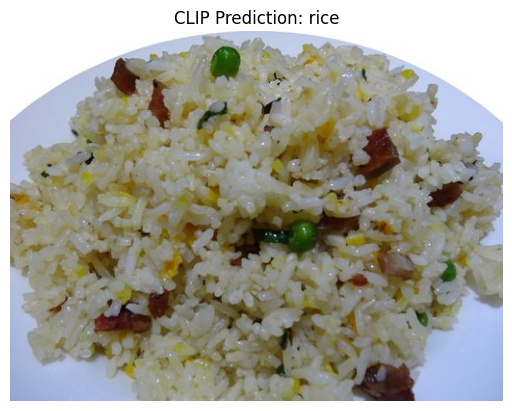

In [15]:
clip_model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

candidate_labels = [
    "bread", "dairy product", "dessert", "egg", "fried food",
    "meat", "noodles or pasta", "rice", "seafood", "soup", "vegetables or fruits"
]

image_paths = [
    "data/food11/validation/Egg/12.jpg",
    "data/food11/validation/Soup/99.jpg",
    "data/food11/validation/Rice/33.jpg"
]

# Loop through images
for path in image_paths:
    if not os.path.exists(path):
        print(f"❌ Not found: {path}")
        continue

    image = Image.open(path)
    inputs = clip_processor(text=candidate_labels, images=image, return_tensors="pt", padding=True)
    outputs = clip_model(**inputs)
    probs = outputs.logits_per_image.softmax(dim=1)[0]

    print(f"\n📷 {os.path.basename(path)}")
    for label, score in zip(candidate_labels, probs):
        print(f"{label:>22}: {score:.4f}")

    plt.imshow(image)
    plt.axis("off")
    plt.title(f"CLIP Prediction: {candidate_labels[probs.argmax()]}")
    plt.show()

## 8. Testing

In [16]:
#Test Logs (runs)
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

ea = EventAccumulator("runs/food11_vit/version_2/events.out.tfevents.1748341338.cs-01jw8m1dexj79btbya518rqzrf.1816.0")
ea.Reload()

print("Logged tags:", ea.Tags())
print("Validation Accuracy:", ea.Scalars("val_acc"))

Logged tags: {'images': [], 'audio': [], 'histograms': [], 'scalars': ['hp_metric', 'train_loss', 'train_acc', 'epoch', 'val_loss', 'val_acc'], 'distributions': [], 'tensors': [], 'graph': False, 'meta_graph': False, 'run_metadata': []}
Validation Accuracy: [ScalarEvent(wall_time=1748341699.65581, step=308, value=0.9530612230300903), ScalarEvent(wall_time=1748342065.3503745, step=617, value=0.9620991349220276), ScalarEvent(wall_time=1748342431.2628999, step=926, value=0.9620991349220276), ScalarEvent(wall_time=1748342797.078509, step=1235, value=0.9588921070098877), ScalarEvent(wall_time=1748343163.0145984, step=1544, value=0.9658892154693604)]


In [17]:
train_loss = ea.Scalars("train_loss")
val_loss = ea.Scalars("val_loss")

for i in range(len(val_loss)):
    print(f"Epoch {i+1} | Step: {val_loss[i].step} | Train Loss: {train_loss[i].value:.4f} | Val Loss: {val_loss[i].value:.4f}")


Epoch 1 | Step: 308 | Train Loss: 1.2517 | Val Loss: 0.1991
Epoch 2 | Step: 617 | Train Loss: 0.4728 | Val Loss: 0.1376
Epoch 3 | Step: 926 | Train Loss: 0.2027 | Val Loss: 0.1281
Epoch 4 | Step: 1235 | Train Loss: 0.2861 | Val Loss: 0.1395
Epoch 5 | Step: 1544 | Train Loss: 0.2943 | Val Loss: 0.1223
